In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import calcLattice
from calcLattice import make_lattice, reset
import draw
from draw import addTripod, make_figure
%matplotlib inline
import matplotlib as mpl
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from calcLattice import tiles, positions_list, orientations_list, types_list
from calcLattice import gluing_mapping

global tiles, positions_list, orientations_list, types_list, gluing_mapping

In [3]:
gluing_mapping.clear()
# gluing_mapping.update({1:0, 2:0, 3:0}) #monomer
# gluing_mapping.update({1:1, 2:0, 3:0}) #dimer
# gluing_mapping.update({1:2, 2:1, 3:0}) # hexamer

# gluing_mapping.update({1:4, 2:3, 3:2, 4:1, 5:0, 6:0}) #snow flake
# gluing_mapping.update({1:4, 2:3, 3:2, 4:1, 5:0, 6:6}) #chiral L
# gluing_mapping.update({1:4, 2:3, 3:2, 4:1, 5:5, 6:0}) #chiral R
# gluing_mapping.update({1:1, 2:2, 3:3, 4:1, 5:5, 6:6}) #lattice without holes

# gluing_mapping.update({1:4, 2:3, 3:2, 4:1, 5:0, 6:7, 7:6, 8:0, 9:0}) #chiral snowflake
# gluing_mapping.update({1:4, 2:3, 3:2, 4:1, 5:0, 6:7, 7:6, 8:8, 9:0}) # big holes
gluing_mapping.update({1:1, 2:4, 3:0, 4:2, 5:0, 6:8, 7:9, 8:6, 9:7}) #triangular holes

### Reset tiles, positions_lists, orientations_list, types_list
reset()
make_lattice()

[300]


In [4]:
from sph_projection_utils import *

In [5]:
np_pos = np.array(positions_list)

In [6]:
N, _ = np_pos.shape
coords = np.zeros((N, N, 3))
for i, pos in enumerate(np_pos):
    coords[i, :, :2] = np_pos - np_pos[i]

In [7]:
phi, theta = xyz_to_phi_theta(coords)
np.fill_diagonal(phi, 0.)
np.fill_diagonal(theta, 0.)
r = np.linalg.norm(coords, axis=-1)

/home/tess/Dropbox/GitHubRepos/linus/sph_projection_utils.py:30: RuntimeWarning:

invalid value encountered in true_divide



In [14]:
# TODO: Add ability to do radial shells
def ylms_within_r_cutoff(coords, r_cutoff):
    phi, theta = xyz_to_phi_theta(coords)
    r = np.linalg.norm(coords, axis=-1)
    r_shape = r.shape  # [N...]
    r.reshape(1, *r_shape) # [1, N...]
    r_cutoff = [r_cutoff] if type(r_cutoff) == float or type(r_cutoff) == int else r_cutoff
    sort_indices = np.argsort(r, axis=-1)
    ylms = get_Ylm_coeffs(phi, theta, sum=False)  # [R, N...]
    output = []
    for r_cut in r_cutoff:
        ylms_cutoff = np.where((r > 0.) & (r <= r_cut), ylms, np.zeros(ylms.shape))
        output.append(ylms_cutoff)
    return output

In [15]:
ylms_within_r_cutoff(coords, 3)[0].shape

/home/tess/Dropbox/GitHubRepos/linus/sph_projection_utils.py:30: RuntimeWarning:

invalid value encountered in true_divide



(36, 302, 302)

In [17]:
sort_indices = np.argsort(r, axis=-1)
N, _ = sort_indices.shape
phi_sorted = phi[np.arange(N).reshape(-1,1),sort_indices[:,1:11]]
theta_sorted = theta[np.arange(N).reshape(-1,1), sort_indices[:,1:11]]

In [23]:
ylms_sorted = get_Ylm_coeffs(phi_sorted, theta_sorted)
ylms = get_Ylm_coeffs(phi, theta)
ylms_cutoff = np.sum(ylms_within_r_cutoff(coords, 5.0)[0], axis=-1)

/home/tess/Dropbox/GitHubRepos/linus/sph_projection_utils.py:30: RuntimeWarning:

invalid value encountered in true_divide



In [24]:
def norm_sph(array):
    N, L_sum = array.shape
    L_max = int(np.sqrt(L_sum - 1))
    output = np.zeros((N, L_max + 1))
    for L in range(L_max + 1):
        output[:, L] = np.linalg.norm(array[:, L ** 2: (L + 1) ** 2], axis=-1)
    return output

In [26]:
local_norms = norm_sph(ylms_sorted.T)
local_cutoff_norms = norm_sph(ylms_cutoff.T)

In [28]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm

# kmeans_norm = KMeans(n_clusters=10, random_state=0).fit(tsne_norms)
# kmeans_sph = KMeans(n_clusters=20, random_state=0).fit(tsne_sorted_results)

kmeans_norm = KMeans(n_clusters=10, random_state=0).fit(local_cutoff_norms)
kmeans_sph = KMeans(n_clusters=20, random_state=0).fit(ylms_cutoff.T)

In [33]:
# norms_colors = kmeans_norm.fit_predict(tsne_norms)
# sph_colors = kmeans_sph.fit_predict(tsne_sorted_results)
norms_colors = kmeans_norm.fit_predict(local_cutoff_norms)
sph_colors = kmeans_sph.fit_predict(ylms_cutoff.T)

In [57]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=5000)
# tsne_full_results = tsne.fit_transform(ylms.T)
# tsne_sorted_results = tsne.fit_transform(ylms_sorted.T)
# tsne_norms = tsne.fit_transform(local_norms)
tsne_cutoff = tsne.fit_transform(ylms_cutoff.T)
tsne_cutoff_norms = tsne.fit_transform(local_cutoff_norms)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.001s...
[t-SNE] Computed neighbors for 302 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.232494
[t-SNE] Error after 3100 iterations: 0.211252
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.000s...
[t-SNE] Computed neighbors for 302 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.726383
[t-SNE] Error after 2950 iterations: 0.128447


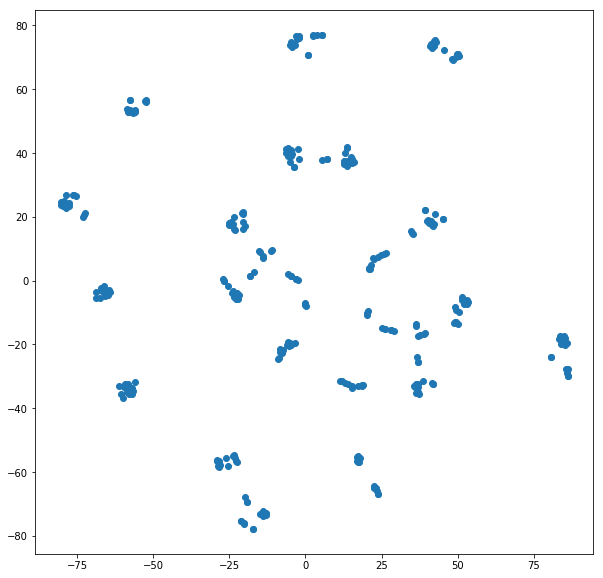

In [58]:
# fig = plt.figure(figsize=(10,10))
# plt.plot(tsne_full_results[:,0], tsne_full_results[:,1], 'o')
fig = plt.figure(figsize=(10,10))
plt.plot(tsne_cutoff[:,0], tsne_cutoff[:,1], 'o')

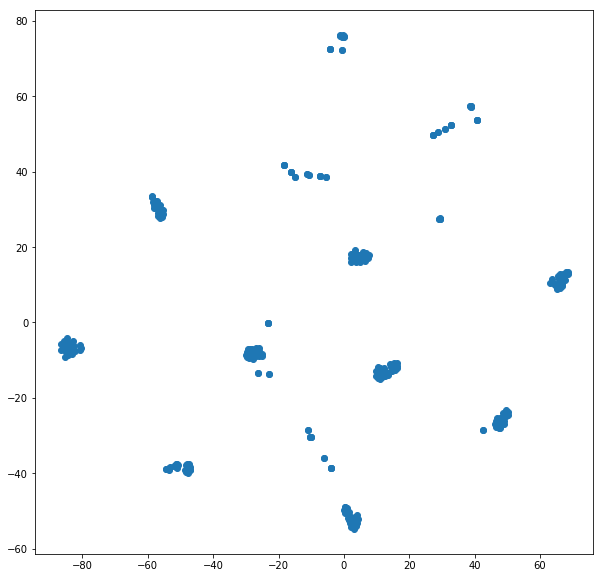

In [59]:
# fig = plt.figure(figsize=(10,10))
# plt.plot(tsne_sorted_results[:,0], tsne_sorted_results[:,1], 'o')
fig = plt.figure(figsize=(10,10))
plt.plot(tsne_cutoff_norms[:,0], tsne_cutoff_norms[:,1], 'o')

In [32]:
# fig = plt.figure(figsize=(10,10))
# plt.plot(tsne_norms[:,0], tsne_norms[:,1], 'o')

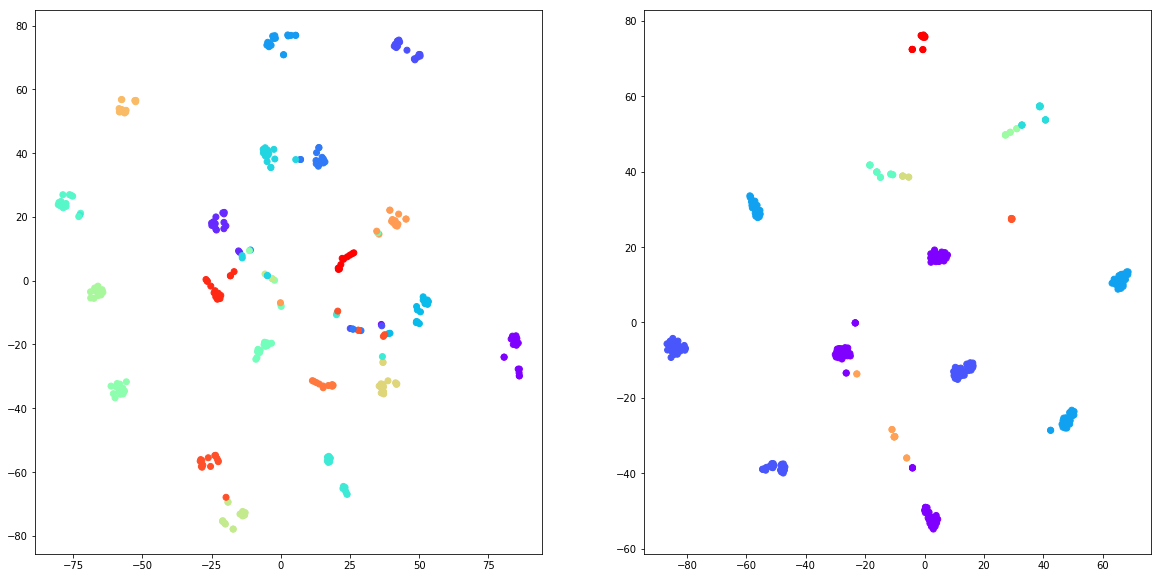

In [60]:
# fig, axes = plt.subplots(1, 2, figsize=(20,10))
# axes[0].scatter(tsne_sorted_results[:,0].tolist(), tsne_sorted_results[:,1].tolist(), c=sph_colors, cmap = cm.rainbow)
# axes[1].scatter(tsne_norms[:,0].tolist(), tsne_norms[:,1].tolist(), c=norms_colors, cmap = cm.rainbow)

fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].scatter(tsne_cutoff[:,0].tolist(), tsne_cutoff[:,1].tolist(), c=sph_colors, cmap = cm.rainbow)
axes[1].scatter(tsne_cutoff_norms[:,0].tolist(), tsne_cutoff_norms[:,1].tolist(), c=norms_colors, cmap = cm.rainbow)

In [36]:
rainbow_bytes = lambda x: cm.rainbow(x, bytes=True)

rgb_colors = ["rgb("+",".join(
    list(
        map(str,
            np.array(rainbow_bytes(i / np.max(norms_colors))[0:3])
           )
    )) + ")" for i in norms_colors]

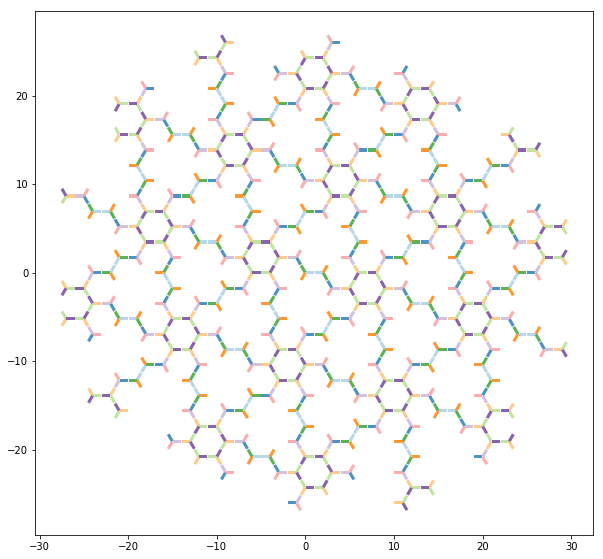

In [37]:
make_figure()
plt.show()

In [38]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import numpy as np
import pandas as pd
from dash.dependencies import Input, Output

In [61]:
# app = dash.Dash(__name__)
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

In [62]:
from pandas import DataFrame
df = DataFrame({
    'lattice_x': np_pos[:, 0],
    'lattice_y': np_pos[:, 1],
#     'tsne_full_x': tsne_full_results[:, 0],
#     'tsne_full_y': tsne_full_results[:, 1],
#     'tsne_local_x': tsne_sorted_results[:, 0],
#     'tsne_local_y': tsne_sorted_results[:, 1],
    'tsne_local_x': tsne_cutoff[:, 0],
    'tsne_local_y': tsne_cutoff[:, 1],
#     'tsne_norms_x': tsne_norms[:, 0],
#     'tsne_norms_y': tsne_norms[:, 1],
    'tsne_norms_x': tsne_cutoff_norms[:, 0],
    'tsne_norms_y': tsne_cutoff_norms[:, 1],
    'colors': rgb_colors,
})

In [63]:
app.layout = html.Div([
    html.Div(
        dcc.Graph(
            id='g1',
            config={'displayModeBar': False}
        ), className='four columns'),
    html.Div(
        dcc.Graph(
            id='g2',
            config={'displayModeBar': False}
        ), className='four columns'),
    html.Div(
        dcc.Graph(
            id='g3',
            config={'displayModeBar': False}
        ), className='four columns'),
#     html.Div(
#         dcc.Graph(
#             id='g4',
#             config={'displayModeBar': False}
#         ), className='three columns'),
], className='row')

In [64]:
app.callback_map = {}

In [65]:
def highlight(x, y):
    def callback(*selectedDatas):
        selectedpoints = df.index
        for i, selected_data in enumerate(selectedDatas):
            if selected_data is not None:
                selected_index = [
                    p['customdata'] for p in selected_data['points']
                ]
                if len(selected_index) > 0:
                    selectedpoints = np.intersect1d(
                        selectedpoints, selected_index)


        # set which points are selected with the `selectedpoints` property
        # and style those points with the `selected` and `unselected`
        # attribute. see
        # https://medium.com/@plotlygraphs/notes-from-the-latest-plotly-js-release-b035a5b43e21
        # for an explanation

        figure = {
            'data': [
                {
                    'x': df[x],
                    'y': df[y],
                    'text': df.index,
                    'textposition': 'top',
                    'selectedpoints': selectedpoints,
                    'customdata': df.index,
                    'type': 'scatter',
                    'mode': 'markers+text',
#                     'color': df['colors'][df.index],
                    'marker': {
#                         'color': 'rgba(0, 116, 217, 0.7)',
                        'color': df.colors,
#                         'color': norms_colors,
#                         'color': np.random.rand(302), # Works
                        'size': 12,
#                         'line': {
#                             'color': 'rgb(0, 116, 217)',
#                             'width': 0.5
#                         }
                    },
                    'textfont': {
                        'color': 'rgba(30, 30, 30, 1)'
                    },
                    'unselected': {
                        'marker': {
                            'color': 'rgba(192, 192, 192, 0.3)',
                            'size': 9,
                            'line': {
                                'color': 'rgba(128, 128, 128, 0.5)',
                                'width': 0
                            }
                        },
                        'textfont': {
                            # make text transparent when not selected
                            'color': 'rgba(0, 0, 0, 0)'
                        }
                    }
                },
            ],
            'layout': {
                'clickmode': 'event+select',
                'margin': {'l': 15, 'r': 0, 'b': 15, 't': 5},
                'dragmode': 'select',
                'hovermode': 'closest',
                'showlegend': False
            }
        }

        # Display a rectangle to highlight the previously selected region
        shape = {
            'type': 'rect',
            'line': {
                'width': 1,
                'dash': 'dot',
                'color': 'darkgrey'
            }
        }
        if selectedDatas[0] and selectedDatas[0]['range']:
            figure['layout']['shapes'] = [dict({
                'x0': selectedDatas[0]['range']['x'][0],
                'x1': selectedDatas[0]['range']['x'][1],
                'y0': selectedDatas[0]['range']['y'][0],
                'y1': selectedDatas[0]['range']['y'][1]
            }, **shape)]
        else:
            figure['layout']['shapes'] = [dict({
                'type': 'rect',
                'x0': np.min(df[x]),
                'x1': np.max(df[x]),
                'y0': np.min(df[y]),
                'y1': np.max(df[y])
            }, **shape)]

        return figure

    return callback

In [66]:
# app.callback is a decorator which means that it takes a function
# as its argument.
# highlight is a function "generator": it's a function that returns function
app.callback(
    Output('g1', 'figure'),
    [Input('g1', 'selectedData'),
     Input('g2', 'selectedData'),
     Input('g3', 'selectedData'),
#      Input('g4', 'selectedData')
    ])(highlight('lattice_x', 'lattice_y'))

app.callback(
    Output('g2', 'figure'),
    [Input('g2', 'selectedData'),
     Input('g1', 'selectedData'),
     Input('g3', 'selectedData'),
#      Input('g4', 'selectedData')
    ])(highlight('tsne_local_x', 'tsne_local_y'))

app.callback(
    Output('g3', 'figure'),
    [Input('g3', 'selectedData'),
     Input('g1', 'selectedData'),
     Input('g2', 'selectedData'),
#      Input('g4', 'selectedData')
    ])(highlight('tsne_norms_x', 'tsne_norms_y'))

# app.callback(
#     Output('g4', 'figure'),
#     [Input('g4', 'selectedData'),
#      Input('g1', 'selectedData'),
#      Input('g2', 'selectedData'),
#      Input('g3', 'selectedData')]
# )(highlight('tsne_norms_x', 'tsne_norms_y'))

<function __main__.highlight.<locals>.callback(*selectedDatas)>

In [68]:
import jupyterlab_dash
viewer = jupyterlab_dash.AppViewer(port=8890, url="0.0.0.0")

In [69]:
viewer.show(app)

In [67]:
viewer.terminate()

In [260]:
norms_argsort = np.argsort(norms_colors)
sph_argsort = np.argsort(sph_colors)

In [70]:
# tsne_sorted_results[sph_argsort]
sph_clusters = {k: [] for k in range(20)}
for k,v in zip(sph_colors, np_pos):
    sph_clusters[k].append(v)

norms_clusters = {k: [] for k in range(10)}
for k,v in zip(norms_colors, np_pos):
    norms_clusters[k].append(v)

In [71]:
import itertools

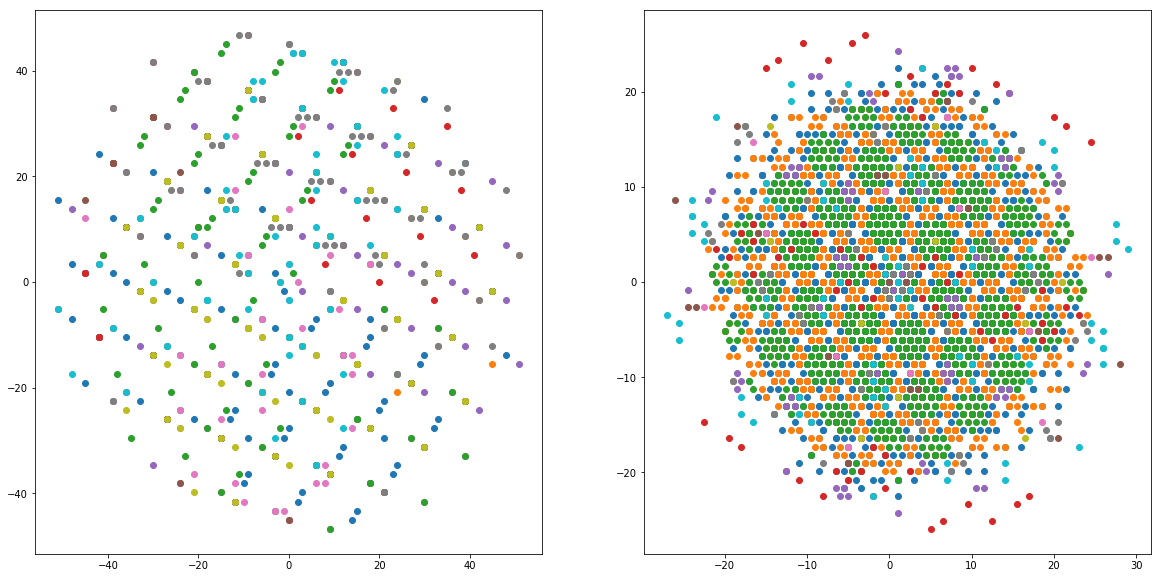

In [72]:
# Get translation vector between sph clusters (identical spherical harmonics)
fig, axes = plt.subplots(1,2, figsize=(20,10))
# diff_vectors = []
for cluster in sph_clusters:
    diff_vectors = []
    points = sph_clusters[cluster]
    for pair in itertools.combinations(range(len(points)), 2):
        one, two = pair
        diff_vectors.append(points[one] - points[two])
    diff_vectors = np.array(diff_vectors)
    axes[0].plot(diff_vectors[:,0], diff_vectors[:,1],'o')
# mid_points = []
for cluster in norms_clusters:
    mid_points = []
    points = norms_clusters[cluster]
    for pair in itertools.combinations(range(len(points)), 2):
        one, two = pair
        mid_points.append((points[one] + points[two]) / 2.)
    mid_points = np.array(mid_points)
    axes[1].plot(mid_points[:,0], mid_points[:,1],'o')